In [49]:
#Loading necessary libraries for the project at hand
import warnings
from azure.storage.blob import BlobClient # Connection to Azure Directory/Blob Service
from collections import Counter
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin #create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) #preprocessing 
from sklearn.decomposition import PCA as pca #dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #Discriminant Analysis
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, cross_val_score,cross_val_predict, GridSearchCV, learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin #create a box-cox transformation
from sklearn.naive_bayes import GaussianNB
from xgboost import (XGBClassifier, plot_importance)
from time import time
from pandasql import sqldf #SQL for data wrangling
import numpy as np  #linear algebra
import pandas as pd  #read and wrangling
import matplotlib.pyplot as plt #visualizations
import seaborn as sns #other visualizations
import transformers #tranformations
from scipy.stats import boxcox # data transform
from datetime import datetime, date
import os, json
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
import pylab
import scipy.stats as stats
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
import json


%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [50]:
#Azure credential and Synthea Datasets
blob = BlobClient(account_url="https://xxxxxxxxxxxx.blob.core.windows.net",
                  container_name="medicationadherence",
                  blob_name="medicationadherencedatasets.csv",
                  credential="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

In [51]:
#Open dataset
with open("medicationadherencedatasets.csv", "wb") as a:
    data = blob.download_blob()
    data.readinto(a)

In [52]:
#Read Synthea Datasets
med_adhere = pd.read_csv("medicationadherencedatasets.csv")

In [53]:
#view sample data
med_adhere.head(3)

,MEDICATIONS_START_YEAR,MEDICATIONS_START,MEDICATIONS_STOP,PATIENT_FHIR_ID,PATIENT_NAME,ENCOUNTER_ID,MEDICATIONS_DESCRIPTION,MEDICATIONS_CONDITIONS,ENCOUNTERCLASS,MEDICATIONS_DISPENSESPERYEAR,...,Calcium_mgperdL,Sodium_mmolperL,Potassium_mmolperL,Chloride_mmolperL,CarbonDioxide_mmolperL,TotalCholesterol_mgperdL,Triglycerides_mgperdL,LowDensityLipoproteinCholesterol_mgperdL,HighDensityLipoproteinCholesterol_mgperdL,HemoglobinA1c
0,2011,2011-04-30T00:26:23Z,2012-04-24T00:26:23Z,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,Mariana775 Rutherford999,6aa37300-d1b4-48e7-a2f8-5e0f70f48f38,Etonogestrel 68 MG Drug Implant,NaN,outpatient,1,...,9.3,140.1,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3
1,2011,2011-05-13T12:58:08Z,2011-05-27T12:58:08Z,10339b10-3cd1-4ac3-ac13-ec26728cb592,Jayson808 Fadel536,e1ab4933-07a1-49f0-b4bd-05500919061d,Acetaminophen 325 MG Oral Tablet,Acute bronchitis (disorder),ambulatory,1,...,9.3,140.1,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3
2,2011,2011-12-08T15:02:18Z,2011-12-22T15:02:18Z,1d604da9-9a81-4ba9-80c2-de3375d59b40,José Eduardo181 Gómez206,792fae81-a007-44b0-8221-46953737b089,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,Viral sinusitis (disorder),ambulatory,1,...,9.3,140.1,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3


In [54]:
#Data types 
med_adhere.dtypes

MEDICATIONS_START_YEAR                         int64
MEDICATIONS_START                             object
MEDICATIONS_STOP                              object
PATIENT_FHIR_ID                               object
PATIENT_NAME                                  object
ENCOUNTER_ID                                  object
MEDICATIONS_DESCRIPTION                       object
MEDICATIONS_CONDITIONS                        object
ENCOUNTERCLASS                                object
MEDICATIONS_DISPENSESPERYEAR                   int64
GROUP_CLASS                                   object
READMISSION_RATE                             float64
Pain_severity_0to10                            int64
Diastolic_BP_mmHg                              int64
Systolic_BP_mmHg                               int64
BodyWeight_kg                                float64
Heartrate_permin                               int64
Respiratoryrate_permin                         int64
BMI_kgperm2                                  f

In [55]:
#Data Summary
med_adhere.describe()

,MEDICATIONS_START_YEAR,MEDICATIONS_DISPENSESPERYEAR,READMISSION_RATE,Pain_severity_0to10,Diastolic_BP_mmHg,Systolic_BP_mmHg,BodyWeight_kg,Heartrate_permin,Respiratoryrate_permin,BMI_kgperm2,...,Calcium_mgperdL,Sodium_mmolperL,Potassium_mmolperL,Chloride_mmolperL,CarbonDioxide_mmolperL,TotalCholesterol_mgperdL,Triglycerides_mgperdL,LowDensityLipoproteinCholesterol_mgperdL,HighDensityLipoproteinCholesterol_mgperdL,HemoglobinA1c
count,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,...,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000,14575.000000
mean,2015.313551,31.552316,0.000721,2.255849,82.282607,124.328165,83.389393,79.771732,14.039794,28.729839,...,9.318484,140.061571,4.483321,106.081722,24.360789,192.456748,146.183396,102.232919,61.500082,4.294271
std,2.671265,59.640120,0.022843,1.311217,8.353143,16.613527,15.329412,9.195480,0.922811,4.670470,...,0.336713,1.605456,0.306871,1.976052,1.808945,16.377150,36.231044,18.708248,9.080525,1.008004
min,2011.000000,1.000000,0.000000,0.000000,68.000000,98.000000,3.000000,60.000000,12.000000,13.500000,...,8.500000,136.000000,3.700000,101.000000,20.000000,150.000000,100.100000,53.400000,20.500000,2.100000
25%,2013.000000,2.000000,0.000000,2.000000,79.000000,118.000000,79.900000,75.000000,14.000000,27.700000,...,9.300000,140.100000,4.500000,106.100000,24.300000,190.900000,141.400000,99.400000,62.400000,4.300000
50%,2015.000000,4.000000,0.000000,2.000000,81.000000,121.000000,84.100000,80.000000,14.000000,28.100000,...,9.300000,140.100000,4.500000,106.100000,24.300000,190.900000,141.400000,99.400000,62.400000,4.300000
75%,2018.000000,19.000000,0.000000,3.000000,83.000000,126.000000,86.700000,84.000000,14.000000,29.100000,...,9.300000,140.100000,4.500000,106.100000,24.300000,190.900000,141.400000,99.400000,62.400000,4.300000
max,2020.000000,221.000000,0.900000,10.000000,121.000000,201.000000,130.200000,100.000000,16.000000,48.500000,...,10.200000,144.000000,5.200000,111.000000,29.000000,296.700000,497.400000,198.300000,80.000000,8.200000


In [56]:
#Select Specific Data Elements for data modeling 
#Data wrangling done already from Patients, Encounters, Observations, Readmissions and Conditions
a="""select 
READMISSION_RATE,
Pain_severity_0to10,
Diastolic_BP_mmHg,
Systolic_BP_mmHg,
BodyWeight_kg,
Heartrate_permin,
Respiratoryrate_permin,
BMI_kgperm2,
Glucose_mgperdL,
UreaNitrogen_mgperdL,
Creatinine_mgperdL,
Calcium_mgperdL,
Sodium_mmolperL,
Potassium_mmolperL,
Chloride_mmolperL,
CarbonDioxide_mmolperL,
TotalCholesterol_mgperdL,
Triglycerides_mgperdL,
LowDensityLipoproteinCholesterol_mgperdL,
HighDensityLipoproteinCholesterol_mgperdL,
HemoglobinA1c,
GROUP_CLASS
from med_adhere ;"""
pysqldf = lambda a: sqldf(a, globals())
Relevant_df = pysqldf(a)

In [57]:
#Adherent Group was determined if the number of dispenses per year per patient is higher than the 3rd quartile of the entire population in consideration
Relevant_df['GROUP_CLASS'].value_counts()

Non-Adherent Group    7358
Adherent Group        7217
Name: GROUP_CLASS, dtype: int64

((array([-3.90273384, -3.68259807, -3.56196687, ...,  3.56196687,
          3.68259807,  3.90273384]),
  array([ 68,  68,  68, ..., 121, 121, 121], dtype=int64)),
 (7.179988811897591, 82.28260720411664, 0.8593660359130525))

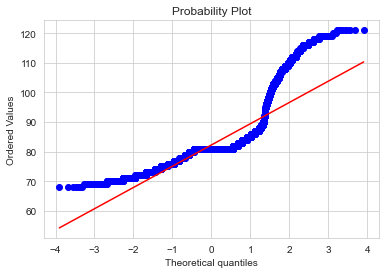

In [58]:
#Test for normality
#READMISSION_RATE
#Pain_severity_0to10
#Diastolic_BP_mmHg
#Systolic_BP_mmHg
#BodyWeight_kg
#Heartrate_permin
#Respiratoryrate_permin
#BMI_kgperm2
#Glucose_mgperdL
#UreaNitrogen_mgperdL
#Creatinine_mgperdL
#Calcium_mgperdL
#Sodium_mmolperL
#Potassium_mmolperL
#Chloride_mmolperL
#CarbonDioxide_mmolperL
#TotalCholesterol_mgperdL
#Triglycerides_mgperdL
#LowDensityLipoproteinCholesterol_mgperdL
#HighDensityLipoproteinCholesterol_mgperdL
#HemoglobinA1c
stats.probplot(Relevant_df['Diastolic_BP_mmHg'], dist="norm",plot=pylab)

In [59]:
dataframe=Relevant_df
features = dataframe.columns[:-1].tolist()
print(dataframe.shape)

(14575, 22)


In [60]:
#Export to csv
dataframe.to_csv(r'C:\Users\olajideajayi\OneDrive - Microsoft\Desktop\WIP\1 ShellyA Pipeline\Tampa General Hospital\dataframe.csv', index = False)

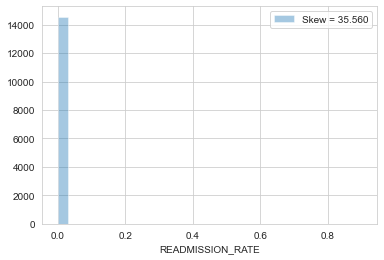

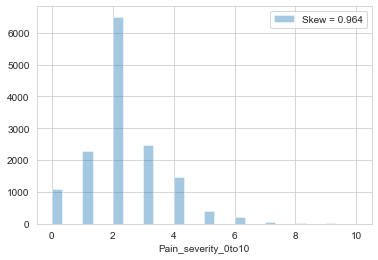

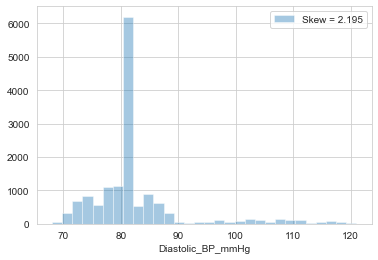

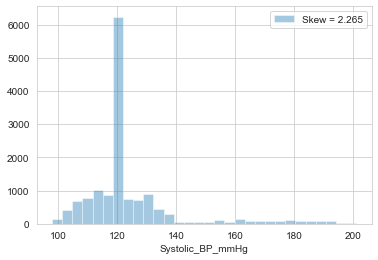

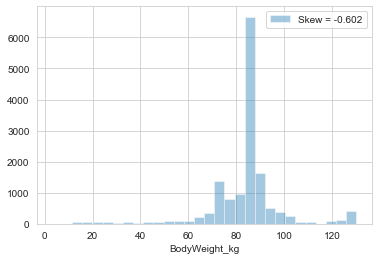

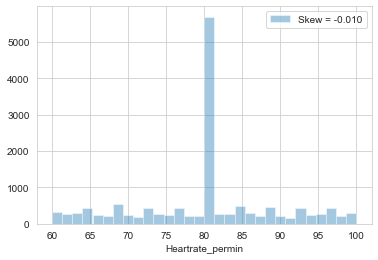

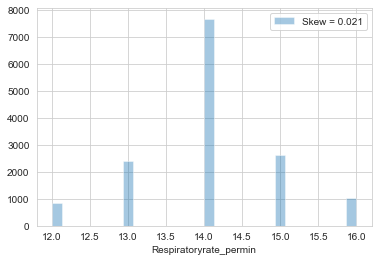

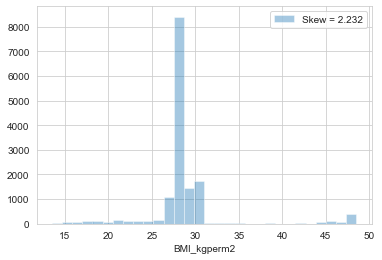

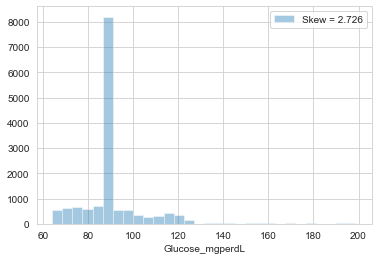

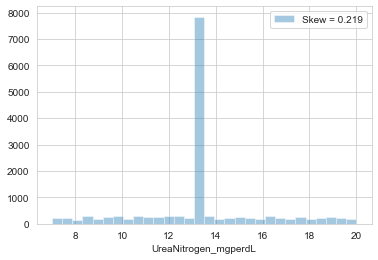

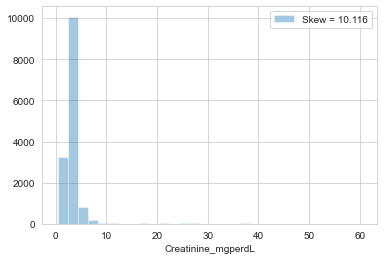

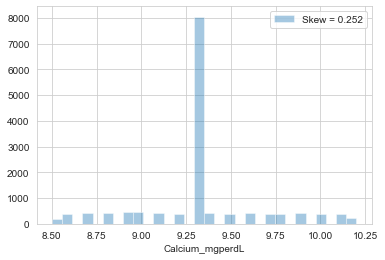

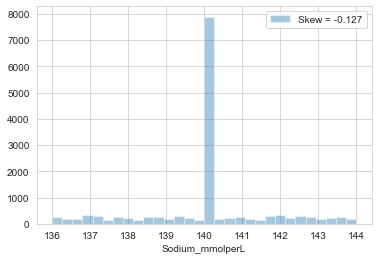

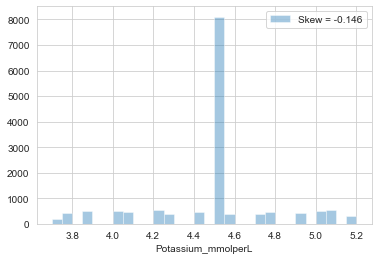

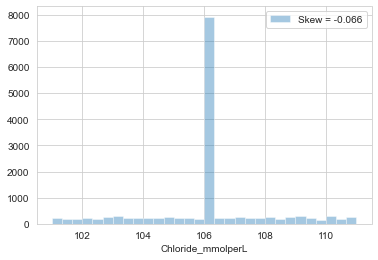

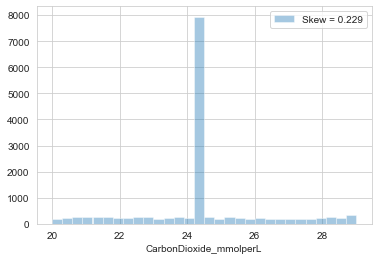

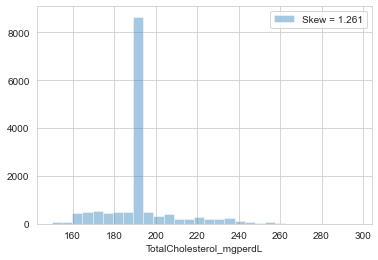

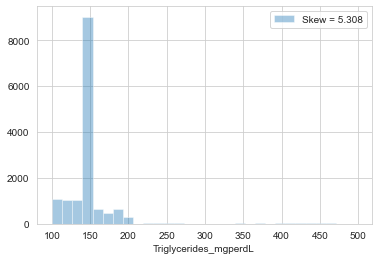

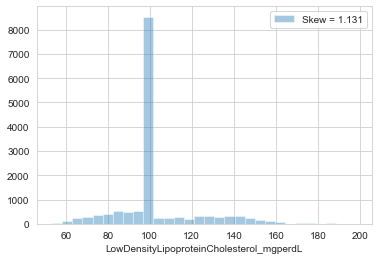

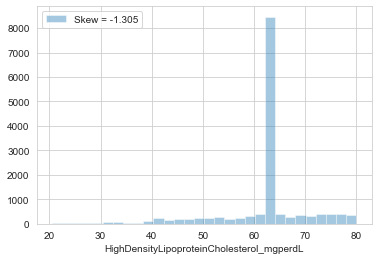

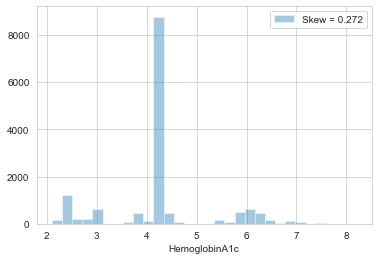

In [61]:
#Data visualization
for feat in features:
    skew = dataframe[feat].skew()
    sns.distplot(dataframe[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()
#the features are not normally distributed

In [62]:
# Detect observations with more than one outlier
#observations containing outliers using Turkey's method

def outlier_hunt(dataframe):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in dataframe.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(dataframe[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(dataframe[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(dataframe[features])))) 

The dataset contains 8500 observations with more than 2 outliers


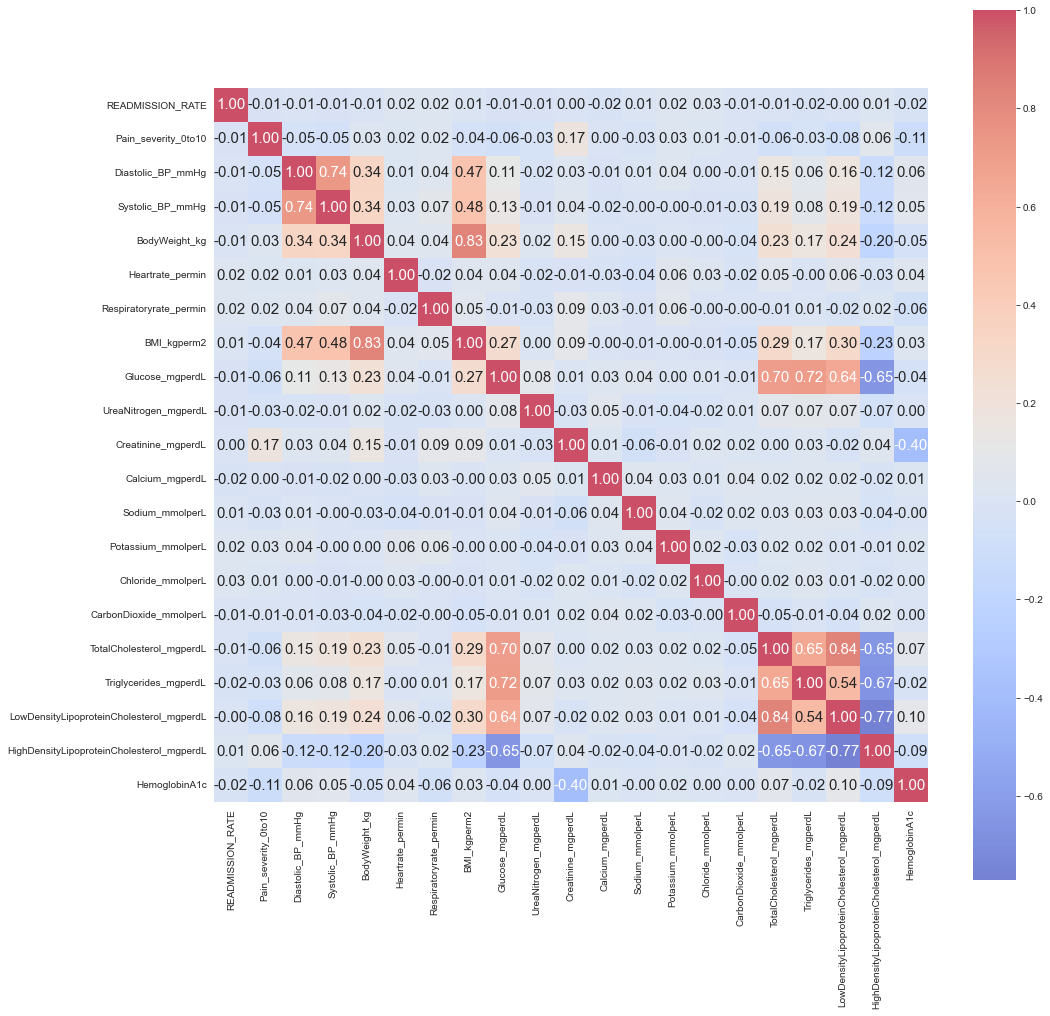

In [63]:
#Heatmaps of correlation
corr = dataframe[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

In [64]:
#Data cleaning
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14575 entries, 0 to 14574
Data columns (total 22 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   READMISSION_RATE                           14575 non-null  float64
 1   Pain_severity_0to10                        14575 non-null  int64  
 2   Diastolic_BP_mmHg                          14575 non-null  int64  
 3   Systolic_BP_mmHg                           14575 non-null  int64  
 4   BodyWeight_kg                              14575 non-null  float64
 5   Heartrate_permin                           14575 non-null  int64  
 6   Respiratoryrate_permin                     14575 non-null  int64  
 7   BMI_kgperm2                                14575 non-null  float64
 8   Glucose_mgperdL                            14575 non-null  float64
 9   UreaNitrogen_mgperdL                       14575 non-null  float64
 10  Creatinine_mgperdL    

In [65]:
#Hunting and removing multiple outliers
outlier_indices = outlier_hunt(dataframe[features])
dataframe = dataframe.drop(outlier_indices).reset_index(drop=True)
print(dataframe.shape)

(6075, 22)


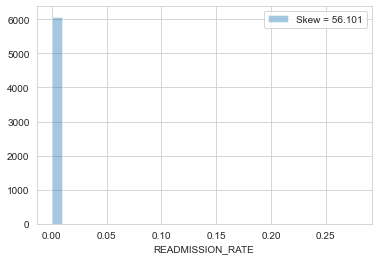

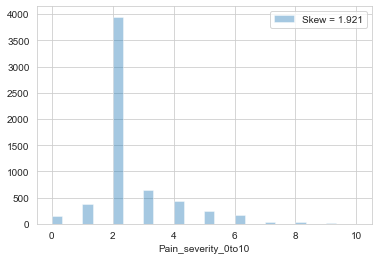

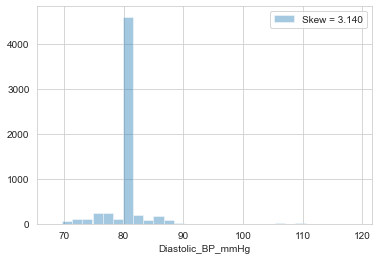

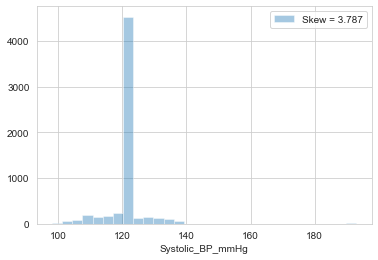

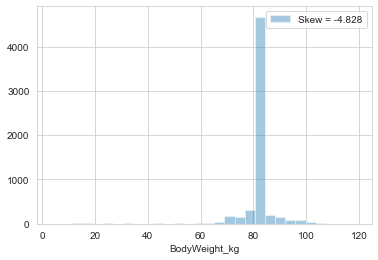

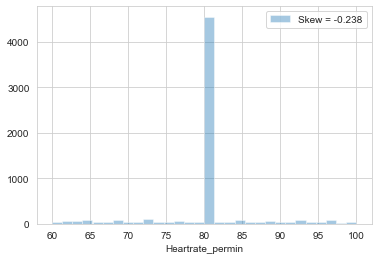

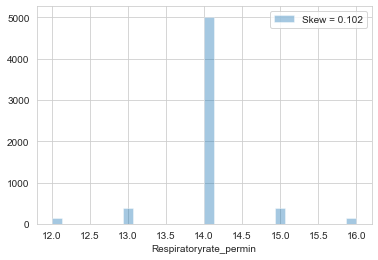

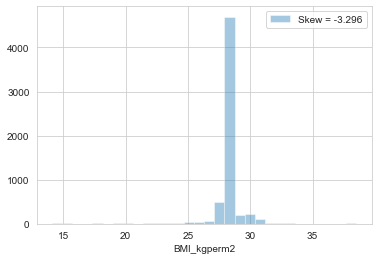

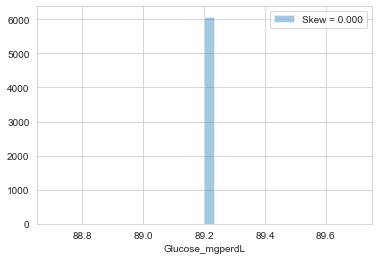

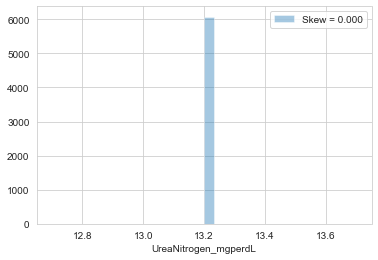

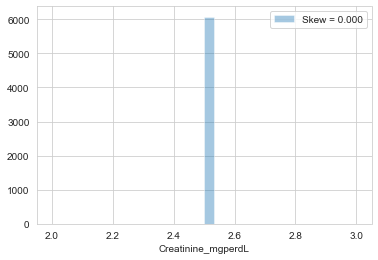

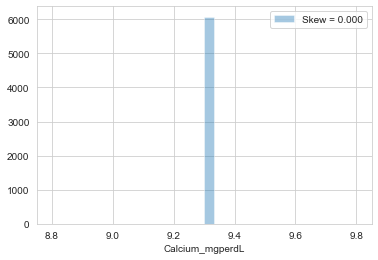

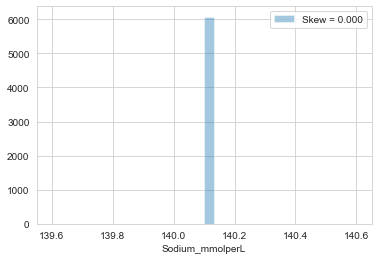

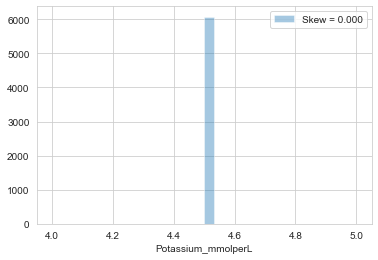

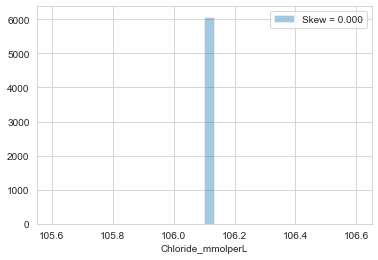

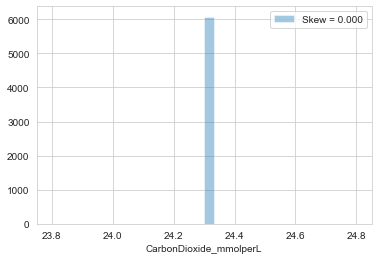

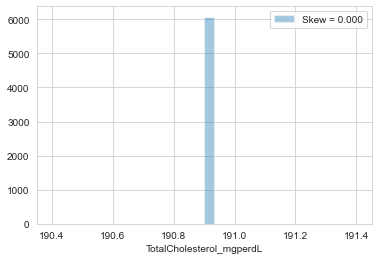

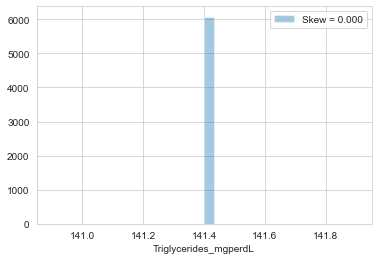

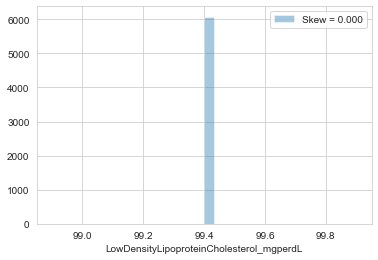

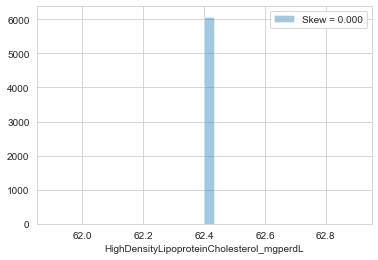

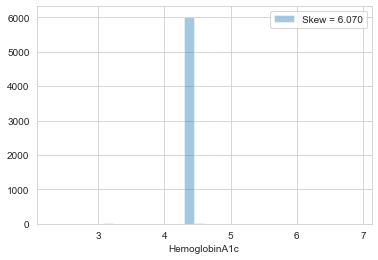

In [66]:
for feat in features:
    skew = dataframe[feat].skew()
    sns.distplot(dataframe[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [67]:
dataframe['GROUP_CLASS'].value_counts()

Non-Adherent Group    4219
Adherent Group        1856
Name: GROUP_CLASS, dtype: int64

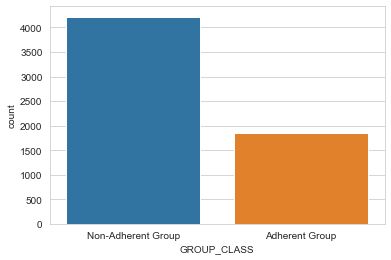

In [20]:
#Distribution of GROUP_CLASS
sns.countplot(dataframe['GROUP_CLASS'])
plt.show()

In [21]:
#Split-out validation dataset
# Define X as features and y as lablels
X = dataframe[features] 
y = dataframe['GROUP_CLASS'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

[09:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to train XGBoost  0.188 seconds


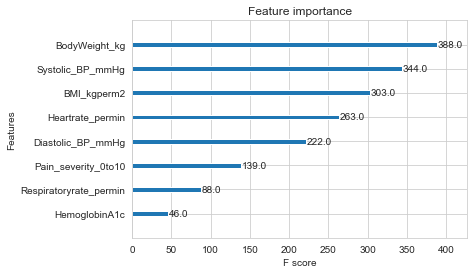

In [22]:
#XGBoost
model_importances = XGBClassifier()
start = time()
model_importances.fit(X_train, y_train)
print('Elapsed time to train XGBoost  %.3f seconds' %(time()-start))
plot_importance(model_importances)
plt.show()

SVC: 82.489712 (+/- 1.527215) performed in 4.239090 seconds
KNN: 82.777778 (+/- 1.506561) performed in 0.231549 seconds
RF: 88.786008 (+/- 1.093636) performed in 1.333195 seconds
Ada: 82.839506 (+/- 1.472883) performed in 3.218663 seconds
ET: 88.971193 (+/- 1.058021) performed in 1.387312 seconds
GB: 85.205761 (+/- 1.576325) performed in 0.538988 seconds
LR: 76.728395 (+/- 1.426892) performed in 0.094404 seconds


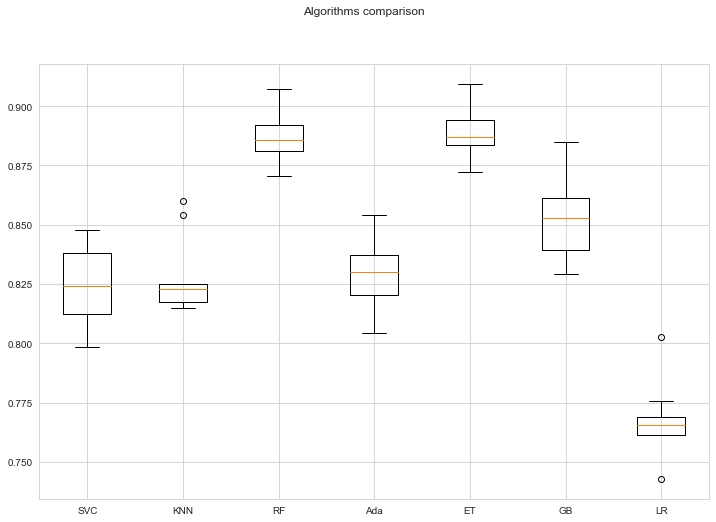

In [23]:
#Compare Models
n_components = 5
pipelines = []
n_estimators = 200

#Algorithms
pipelines.append( ('SVC',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ),
                             ('SVC', SVC(random_state=seed))]) ) )

pipelines.append(('KNN',
                  Pipeline([ 
                              ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ),
                            ('KNN', KNeighborsClassifier()) ])))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))

pipelines.append( ('Ada',
                   Pipeline([ 
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                    ('Ada', AdaBoostClassifier(random_state=seed,  n_estimators=n_estimators)) ]) ))

pipelines.append( ('ET',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('ET', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))
pipelines.append( ('GB',
                   Pipeline([ 
                             ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('GB', GradientBoostingClassifier(random_state=seed)) ]) ))

pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))

results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds,shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring,
                                n_jobs=-1) 
    t_elapsed = time() - start
    results.append(cv_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_results.mean(), 
                                                       100*cv_results.std(), t_elapsed)
    print(msg)


fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [24]:
#Algorithm Tuning
# Create a pipeline 
pipe_et = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('et',  ExtraTreesClassifier(random_state=seed, n_jobs=-1) )])

# Set the grid parameters
param_grid_et =  [ {
    'et__n_estimators': [100, 200,300,400], # number of estimators
    #'et__criterion': ['gini', 'entropy'],   # Splitting criterion
    'et__max_features':[0.05 , 0.1], # maximum features used at each split
    'et__max_depth': [None, 5], # Max depth of the trees
    'et__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=num_folds,shuffle=True, random_state= seed)
grid_et = GridSearchCV(pipe_et, param_grid= param_grid_et, cv=kfold, scoring=scoring, verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_et = grid_et.fit(X_train, y_train)
end = time()

print("ET grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_et.best_score_ * 100.0)
print('-------Best params----------')
print(grid_et.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
ET grid search took 37.670 seconds
-------Best score----------
84.13580246913581
-------Best params----------
{'et__max_depth': None, 'et__max_features': 0.1, 'et__min_samples_split': 0.005, 'et__n_estimators': 100}


In [25]:
#Diagnosis of best algorithm
# Let's define some utility functions to plot the learning & validation curves

def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel('Accuracy')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()    
    
def plot_validation_curve(param_range, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(param_range,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(param_range, test_mean, label='test score', color='red', marker='o')
    plt.fill_between(param_range,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.grid(ls='--')
    plt.xlabel('Parameter value')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

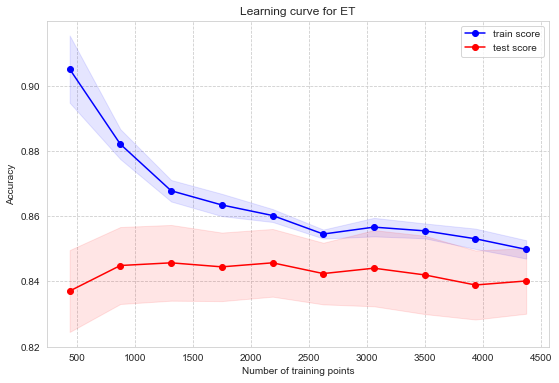

In [26]:
#Plot performance
#Predictions...
plt.figure(figsize=(9,6))

train_sizes, train_scores, test_scores = learning_curve(
              estimator= grid_et.best_estimator_ , X= X_train, y = y_train, 
                train_sizes=np.arange(0.1,1.1,0.1), cv= 10,  scoring='accuracy', n_jobs= - 1)

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for ET')

In [27]:
clf =  ExtraTreesClassifier()
# create pipeline
estimators = [('standardize' , StandardScaler()),('rfecv', RFECV(estimator=clf, scoring='accuracy'))]

In [28]:
# build the pipeline
pipeline = Pipeline(estimators) 

In [29]:
#Run pipeline to get predictions
X = dataframe[features] 
Y = dataframe['GROUP_CLASS'] 
kf = KFold(n_splits=2, shuffle=True, random_state=0)
ypredict = cross_val_predict(pipeline, X, Y, cv=kf)
accuracy = accuracy_score(Y, ypredict)

In [30]:
print(accuracy)

0.877201646090535


In [31]:
#Convert predcition to dataframes
pred=pd.DataFrame.from_dict(ypredict)

In [32]:
#Combine dataframe and predictions
Dataframe_Prediction=pd.concat([dataframe, pred], axis=1, ignore_index=True)

In [33]:
Dataframe_Prediction.head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
1,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
2,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
3,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
4,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group


In [34]:
#Include column names
Consolidated = Dataframe_Prediction.rename(columns = {0:'READMISSION_RATE',1:'Pain_severity_0to10',2:'Diastolic_BP_mmHg',3:'Systolic_BP_mmHg',4:'BodyWeight_kg',5:'Heartrate_permin',6:'Respiratoryrate_permin',7:'BMI_kgperm2',8:'Glucose_mgperdL',9:'UreaNitrogen_mgperdL',10:'Creatinine_mgperdL',11:'Calcium_mgperdL',12:'Sodium_mmolperL',13:'Potassium_mmolperL',14:'Chloride_mmolperL',15:'CarbonDioxide_mmolperL',16:'TotalCholesterol_mgperdL',17:'Triglycerides_mgperdL',18:'LowDensityLipoproteinCholesterol_mgperdL',19:'HighDensityLipoproteinCholesterol_mgperdL',20:'HemoglobinA1c',21:'GROUP_CLASS',22:'PREDICTED_GROUP_CLASS',}, inplace = False)

In [35]:
Med_Adhere_Final_Results=Consolidated

In [36]:
Med_Adhere_Final_Results.head(20)

,READMISSION_RATE,Pain_severity_0to10,Diastolic_BP_mmHg,Systolic_BP_mmHg,BodyWeight_kg,Heartrate_permin,Respiratoryrate_permin,BMI_kgperm2,Glucose_mgperdL,UreaNitrogen_mgperdL,...,Potassium_mmolperL,Chloride_mmolperL,CarbonDioxide_mmolperL,TotalCholesterol_mgperdL,Triglycerides_mgperdL,LowDensityLipoproteinCholesterol_mgperdL,HighDensityLipoproteinCholesterol_mgperdL,HemoglobinA1c,GROUP_CLASS,PREDICTED_GROUP_CLASS
0,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
1,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
2,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
3,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
4,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
5,0.0,3,86,129,79.5,63,13,27.7,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
6,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
7,0.0,2,76,113,85.6,62,14,30.0,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
8,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Non-Adherent Group,Non-Adherent Group
9,0.0,2,81,121,84.1,80,14,28.1,89.2,13.2,...,4.5,106.1,24.3,190.9,141.4,99.4,62.4,4.3,Adherent Group,Non-Adherent Group


In [37]:
#Export Final_Results to csv
Med_Adhere_Final_Results.to_csv(r'C:\Users\olajideajayi\OneDrive - Microsoft\Desktop\WIP\Medication Adherence\Med_Adhere_Final_Results.csv', index = False)

In [73]:
#Conditions Count
med_adhere['MEDICATIONS_CONDITIONS'].value_counts()

Hypertension                                              2806
Diabetes                                                  2059
Childhood asthma                                          1092
Anemia (disorder)                                          959
Hyperlipidemia                                             785
Acute bronchitis (disorder)                                481
Viral sinusitis (disorder)                                 203
Streptococcal sore throat (disorder)                       112
Chronic congestive heart failure (disorder)                 85
Pulmonary emphysema (disorder)                              80
Escherichia coli urinary tract infection                    78
Chronic obstructive bronchitis (disorder)                   62
Cystitis                                                    50
Alzheimer's disease (disorder)                              20
Osteoarthritis of knee                                      18
Sinusitis (disorder)                                   

In [74]:
#Diseases of Interest based on volume, data input on conditions limited
z="""select * from med_adhere where MEDICATIONS_CONDITIONS in ('Hypertension','Hyperlipidemia','Diabetes');"""
pysqldf = lambda z: sqldf(z, globals())
Med_Adhere_Data_1 = pysqldf(z)

In [75]:
#load data for visualization 
Med_Adhere_Data=Med_Adhere_Data_1.to_csv(index = False)

In [80]:
from azure.storage.blob import BlobClient

In [81]:
storage_connection_string='xxxxxxxxxxxxxxxxx'
container_name = 'medadhereout'
dest_file_name = 'Med_Adhere_Data.csv'

In [82]:
blob_client = BlobClient.from_connection_string(storage_connection_string,container_name,dest_file_name)

In [83]:
csv_content = Med_Adhere_Data
blob_client.upload_blob(csv_content)

{'etag': '"0x8DA47C1F67D2AFC"',
 'last_modified': datetime.datetime(2022, 6, 6, 13, 39, 21, tzinfo=datetime.timezone.utc),
 'content_md5': bytearray(b'\x03hi]\x95\xd8\xb5o\xf6\xd8\xa5\xeeA\xac\xbf\xd0'),
 'client_request_id': '11f3d7f9-e59e-11ec-a4fe-a864f1bf2be6',
 'request_id': 'eac10698-c01e-0048-6caa-79d8d8000000',
 'version': '2020-10-02',
 'version_id': None,
 'date': datetime.datetime(2022, 6, 6, 13, 39, 21, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}